# Book Recommendation System

In [1]:
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import warnings
warnings.filterwarnings('ignore')

# EDA

The purpose of doing some exploratory data analysis is to first understand the composition of the data, getting a feel for the data and getting to know the strengths and limitations of the data.

In [2]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [4]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [5]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [6]:
books.isnull().sum()

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64

In [7]:
books.shape

(271360, 8)

In [8]:
ratings.shape

(1149780, 3)

In [9]:
# As you can see there are multiple books of the same title that have more than one ISBN number

books.groupby("Book-Title").agg({"ISBN":"count"}).sort_values("ISBN",ascending=False).head(10)

,ISBN
Book-Title,
Selected Poems,27
Little Women,24
Wuthering Heights,21
Dracula,20
Adventures of Huckleberry Finn,20
The Secret Garden,20
Jane Eyre,19
The Night Before Christmas,18
Pride and Prejudice,18


In [10]:
# Merging the books and ratings dataframes to analyse the book titles in conjunction with the ratings.
df_ratings_books = books.merge(ratings, how='left', on='ISBN')
df_ratings_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2.0,0.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8.0,5.0
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400.0,0.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676.0,8.0
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385.0,0.0


In [11]:
df_ratings_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1032345 entries, 0 to 1032344
Data columns (total 10 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ISBN                 1032345 non-null  object 
 1   Book-Title           1032345 non-null  object 
 2   Book-Author          1032343 non-null  object 
 3   Year-Of-Publication  1032345 non-null  object 
 4   Publisher            1032343 non-null  object 
 5   Image-URL-S          1032345 non-null  object 
 6   Image-URL-M          1032345 non-null  object 
 7   Image-URL-L          1032341 non-null  object 
 8   User-ID              1031136 non-null  float64
 9   Book-Rating          1031136 non-null  float64
dtypes: float64(2), object(8)
memory usage: 78.8+ MB


In [12]:
# Understanding the NULL situation :)
df_ratings_books.isnull().sum()

ISBN                      0
Book-Title                0
Book-Author               2
Year-Of-Publication       0
Publisher                 2
Image-URL-S               0
Image-URL-M               0
Image-URL-L               4
User-ID                1209
Book-Rating            1209
dtype: int64

In [13]:
# Getting the overall book rating
check = df_ratings_books.groupby("Book-Title").agg({"Book-Rating":["count","mean"]})
check = check.droplevel(0, axis = 1)
# Sorting book titles based on highest 'count'
check = check.sort_values("count", ascending = False)
check.head(10)
# We see that Wild Animus is an extremely popular book even though no one likes it apparently

,count,mean
Book-Title,,
Wild Animus,2502,1.019584
The Lovely Bones: A Novel,1295,4.468726
The Da Vinci Code,898,4.642539
A Painted House,838,3.231504
The Nanny Diaries: A Novel,828,3.530193
Bridget Jones's Diary,815,3.527607
The Secret Life of Bees,774,4.447028
Divine Secrets of the Ya-Ya Sisterhood: A Novel,740,3.437838
The Red Tent (Bestselling Backlist),723,4.334716


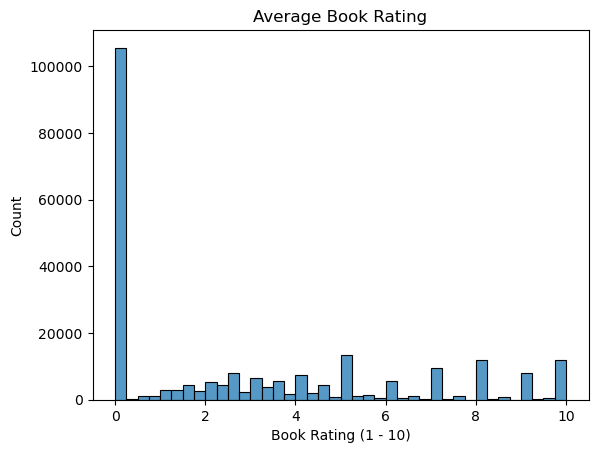

In [14]:
# Finding out the average book rating
average_book_rating = df_ratings_books.groupby("Book-Title")["Book-Rating"].mean()
sns.histplot(data = average_book_rating, bins = 40)
plt.title("Average Book Rating")
plt.xlabel("Book Rating (1 - 10)")
plt.ylabel("Count")
plt.show()

<Axes: xlabel='Age', ylabel='Count'>

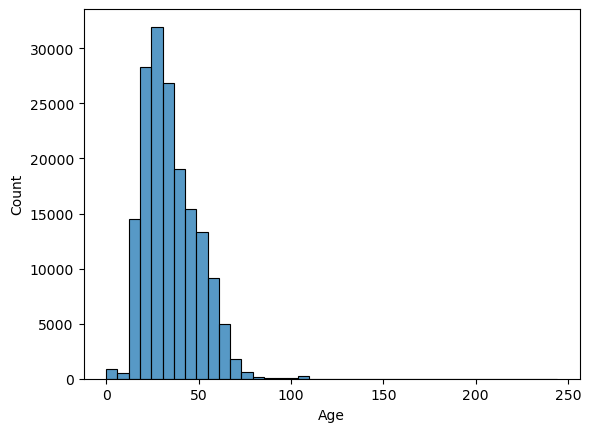

In [15]:
#Getting an understanding of the age demographic of the dataset and how it can be potentially used.
sns.histplot(data = users["Age"], bins = 40)

In [16]:
# So what books do people actually seem to like?
check = check[check["mean"] > 4].sort_values("count", ascending=False)
check.head(20)

,count,mean
Book-Title,,
The Lovely Bones: A Novel,1295,4.468726
The Da Vinci Code,898,4.642539
The Secret Life of Bees,774,4.447028
The Red Tent (Bestselling Backlist),723,4.334716
Life of Pi,664,4.088855
Where the Heart Is (Oprah's Book Club (Paperback)),585,4.105983
Harry Potter and the Sorcerer's Stone (Harry Potter (Paperback)),575,4.895652
Harry Potter and the Chamber of Secrets (Book 2),556,5.183453
Girl with a Pearl Earring,526,4.218631


In [17]:
# Now we actually see some books that we recognise, not just Wild Animus apparently.

In [18]:
# Getting an understanding of how active users are when they are giving reviews
ratings_per_user = df_ratings_books.groupby("User-ID").count()["Book-Rating"]
Q1 = ratings_per_user.quantile(0.25)
Q3 = ratings_per_user.quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

filtered_review_counts = ratings_per_user[(ratings_per_user >= lower_bound) & (ratings_per_user <= upper_bound)]

Text(0.5, 1.0, 'Distribution of Number of Reviews Per User')

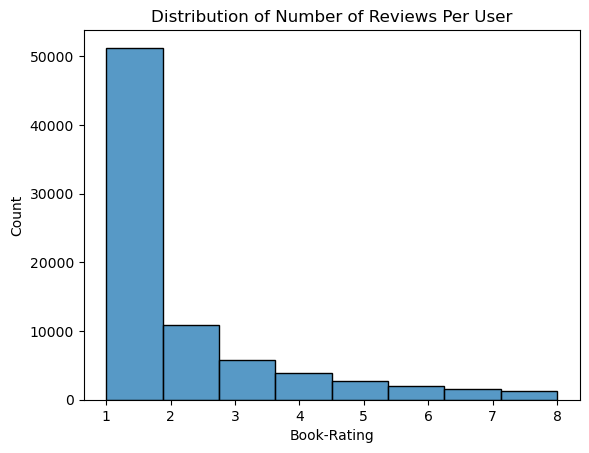

In [19]:
sns.histplot(data = filtered_review_counts, bins = 8)
plt.title("Distribution of Number of Reviews Per User")

We can see the vast majority of people only leave one review, which is not very useful for collaborative filtering or calculating cosine similarity

Text(0.5, 1.0, 'Distribution of Number of Reviews Per User')

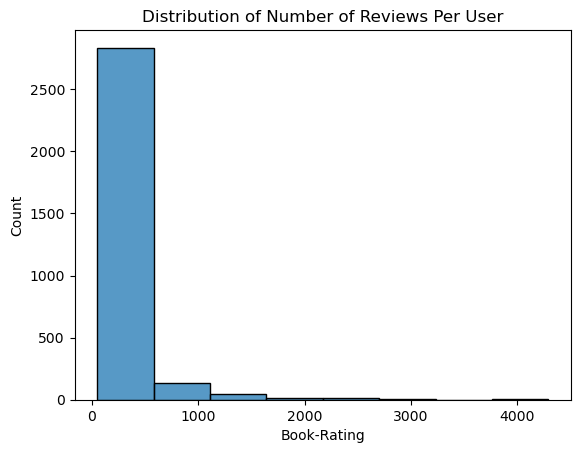

In [20]:
relevant_review_counts = ratings_per_user[(ratings_per_user >= 50) & (ratings_per_user < 5000)]
sns.histplot(data = relevant_review_counts, bins = 8)
plt.title("Distribution of Number of Reviews Per User")

We have to make a decision, a cutoff, a balance between enough total data points and enough reviews to be considered in collaborative filtering.

In [21]:
new = df_ratings_books.groupby("User-ID").count()['Book-Rating'] > 100
user_id_rating_index = new[new].index

In [22]:
filtered_rating = df_ratings_books[df_ratings_books["User-ID"].isin(user_id_rating_index)]

In [23]:
y = filtered_rating.groupby('Book-Title').count()['Book-Rating']>= 50
book_title_rating_index = y[y].index

In [24]:
final_ratings = filtered_rating[filtered_rating['Book-Title'].isin(book_title_rating_index)]
print(final_ratings[['Book-Title','Book-Rating','User-ID']])

                                             Book-Title  Book-Rating   User-ID
31                               The Kitchen God's Wife          9.0   11676.0
32                               The Kitchen God's Wife          9.0   29526.0
33                               The Kitchen God's Wife          0.0   36836.0
34                               The Kitchen God's Wife          9.0   46398.0
38                               The Kitchen God's Wife          0.0  113270.0
...                                                 ...          ...       ...
1029730                                     The Promise          7.0  239594.0
1029943                        The Pillars of the Earth          0.0  240144.0
1029945                             The Handmaid's Tale          0.0  240144.0
1031642                                       Lightning          9.0  244685.0
1032154  The Two Towers (The Lord of the Rings, Part 2)         10.0  259901.0

[97540 rows x 3 columns]


In [25]:
collab_grid = final_ratings.pivot_table(index='Book-Title',columns='User-ID',values='Book-Rating')

In [26]:
collab_grid.fillna(0,inplace=True)

In [27]:
collab_grid.loc['1984']

User-ID
254.0       9.0
507.0       0.0
882.0       0.0
1424.0      0.0
1435.0      0.0
           ... 
277478.0    0.0
277639.0    0.0
278137.0    0.0
278188.0    0.0
278418.0    0.0
Name: 1984, Length: 1634, dtype: float64

In [28]:
#Using collaborative filtering with cosine similarity
cosine_sim_grid = cosine_similarity(collab_grid)

In [29]:
cosine_sim_grid.shape

(1070, 1070)

In [30]:
cosine_sim_grid

array([[1.        , 0.06550754, 0.09317747, ..., 0.07547772, 0.05810769,
        0.03029366],
       [0.06550754, 1.        , 0.02247675, ..., 0.04739871, 0.13548709,
        0.12388301],
       [0.09317747, 0.02247675, 1.        , ..., 0.09310325, 0.        ,
        0.        ],
       ...,
       [0.07547772, 0.04739871, 0.09310325, ..., 1.        , 0.05583662,
        0.0137213 ],
       [0.05810769, 0.13548709, 0.        , ..., 0.05583662, 1.        ,
        0.09410287],
       [0.03029366, 0.12388301, 0.        , ..., 0.0137213 , 0.09410287,
        1.        ]])

In [31]:
import heapq

def recommend_book(book_name):
    index = np.where(collab_grid.index==book_name)[0][0]
    top_similar_items =  heapq.nlargest(6, enumerate(cosine_sim_grid[index]), key=lambda x: x[1])
    similar_items = top_similar_items[1:]

    item_details = []

    similar_book_indices = [i[0] for i in similar_items]
    # Find the titles of similar books
    similar_books_titles = collab_grid.index[similar_book_indices]

    # Filter the books DataFrame for the similar books
    similar_books_df = books[books['Book-Title'].isin(similar_books_titles)]
    # Drop duplicates to ensure each book is represented once
    similar_books_df_unique = similar_books_df.drop_duplicates(subset='Book-Title', keep='first')

    # Select required columns
    data = similar_books_df_unique[['Book-Title', 'Book-Author', 'Image-URL-M']].values.tolist()

    return data


In [32]:
recommend_book('Animal Farm')

[['The Catcher in the Rye',
  'J.D. Salinger',
  'http://images.amazon.com/images/P/0316769487.01.MZZZZZZZ.jpg'],
 ['1984',
  'George Orwell',
  'http://images.amazon.com/images/P/0451524934.01.MZZZZZZZ.jpg'],
 ['Brave New World',
  'Aldous Huxley',
  'http://images.amazon.com/images/P/0060809833.01.MZZZZZZZ.jpg'],
 ['Angus, Thongs and Full-Frontal Snogging: Confessions of Georgia Nicolson',
  'Louise Rennison',
  'http://images.amazon.com/images/P/0064472272.01.MZZZZZZZ.jpg'],
 ['Second Nature',
  'Alice Hoffman',
  'http://images.amazon.com/images/P/0399139087.01.MZZZZZZZ.jpg']]

# Collaborative Filtering w/ Locality Sensitive Hashing

Locality-Sensitive Hashing (LSH) offers several advantages, particularly in the context of handling high-dimensional data and facilitating efficient similarity search, which are critical in applications like recommendation systems, near-duplicate detection, and image or document retrieval.

One of the primary benefits of LSH is its ability to reduce dimensionality and search space significantly, enabling faster query processing times compared to exhaustive search methods, especially in large datasets. By grouping similar items into the same "buckets" with a high probability, LSH maintains an admirable balance between accuracy and computational efficiency, allowing for near-real-time querying. Furthermore, LSH's flexibility in choosing hash functions and parameters tailored to specific similarity measures (e.g., Jaccard, cosine) enhances its effectiveness across various data types and applications.

This method scales well with data size and dimensionality, making it highly suitable for big data scenarios where traditional methods falter due to the "curse of dimensionality."

Since we used cosine similarity for our initial recommendation system. A random projection based LSH would be more appropriate but if we were instead using a Jaccard based similarity a MinHash system would be more appropriate.

In [33]:
ex = collab_grid.to_numpy()
ex.shape

(1070, 1634)

In [34]:
ex

array([[9., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [35]:
!pip install faiss-cpu


Faiss, developed by Facebook AI Research (FAIR), is a comprehensive library for efficient similarity search and clustering of dense vectors. It excels in handling large datasets, allowing for rapid retrieval of items similar to a given query, which is crucial for tasks like recommendation systems, image search, and clustering.

The `IndexLSH` in Faiss is specifically designed for handling high-dimensional data through the use of Locality-Sensitive Hashing (LSH). LSH is a technique that hashes input items in such a way that similar items map to the same "buckets" with high probability. This approach makes searches efficient even in very large datasets by reducing the dimensionality of the data and focusing search efforts on buckets likely to contain similar items.

In [36]:
import faiss

In [37]:
d = ex.shape[1]
d

1634

In [38]:
index = faiss.IndexLSH(d, 4)

In [39]:
index.is_trained

True

In [40]:
index.add(ex)

In [41]:
queries = collab_grid.iloc[0:1].to_numpy()
q = ex[0]
q.reshape((1,-1))
queries.shape

(1, 1634)

In [42]:
k = 100
D, I = index.search(queries, k)

In [43]:
I

array([[   0,   14,   38,   42,   79,   93,   99,  110,  116,  132,  144,
         145,  162,  168,  176,  181,  190,  197,  204,  262,  263,  279,
         310,  330,  332,  334,  369,  387,  402,  419,  463,  479,  483,
         484,  493,  504,  505,  509,  519,  531,  535,  596,  604,  607,
         626,  649,  650,  652,  656,  665,  673,  681,  695,  717,  722,
         733,  744,  747,  762,  768,  777,  784,  787,  835,  841,  842,
         859,  863,  867,  895,  898,  931,  938,  940,  948,  949,  969,
         985,  988,  992,  996, 1021, 1029, 1037, 1038, 1057, 1060, 1067,
           4,    6,   16,   22,   23,   26,   27,   29,   32,   36,   43,
          46]], dtype=int64)

In [44]:
cos_sim = cosine_similarity(ex[I[0]], queries)
cos_sim.mean()

0.05647985076480734

In [45]:
cos_sim = cosine_similarity(ex, queries)
cos_sim.mean()

0.04235736615241688

In [46]:
D

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1.]], dtype=float32)

In [47]:
# Since the tendency with LSH is to have a few buckets with a significant portion of the items,
# generally speaking it's good to have more buckets than elements to reduce the chance of false
# positives along wiht improved precision as similar items can be clustered more tightly together.
for nbits in [2, 4, 6, 8, 10, 12, 14, 16]:
    buckets = 1 << nbits
    print(f"nbits = {nbits}")
    print(f"{ex.shape[0]} / {buckets} = {ex.shape[0]/buckets}")

nbits = 2
1070 / 4 = 267.5
nbits = 4
1070 / 16 = 66.875
nbits = 6
1070 / 64 = 16.71875
nbits = 8
1070 / 256 = 4.1796875
nbits = 10
1070 / 1024 = 1.044921875
nbits = 12
1070 / 4096 = 0.26123046875
nbits = 14
1070 / 16384 = 0.0653076171875
nbits = 16
1070 / 65536 = 0.016326904296875


In [48]:
#Choosing Good Buckets

for nbits in [2, 4, 8, 16, 24, 32, 48, 64, 128, 256, 512, 768]:
    index = faiss.IndexLSH(d, nbits)
    index.add(ex)
    D, I = index.search(ex[6].reshape((1,-1)), k)
    cos = cosine_similarity(ex[I[0]], queries)
    print(f"nbits = {nbits}")
    print(f"sim: {cos.mean()}")

nbits = 2
sim: 0.036334443628718203
nbits = 4
sim: 0.06285069778358147
nbits = 8
sim: 0.03845606050944478
nbits = 16
sim: 0.03142432326560882
nbits = 24
sim: 0.03771130270095232
nbits = 32
sim: 0.05272186992192931
nbits = 48
sim: 0.03494501523950675
nbits = 64
sim: 0.04589483665944031
nbits = 128
sim: 0.043021838419761274
nbits = 256
sim: 0.03931886801025212
nbits = 512
sim: 0.047161754765130307
nbits = 768
sim: 0.04187253958641512


In [49]:
buckets

65536

In [50]:
def recommend_book_lsh(book_name,  n_neighbours: int, nbits=512):
    book_index = np.where(collab_grid.index==book_name)[0][0]
    index = faiss.IndexLSH(ex.shape[1], nbits)
    index.add(ex)
    query = ex[book_index].reshape((1,-1))
    D, I = index.search(query, n_neighbours + 1)

    similar_book_indices = I[0][1:]  # Exclude the first item (itself)

    # Find the titles of similar books
    similar_books_titles = collab_grid.index[similar_book_indices]

    # Filter the books DataFrame for the similar books
    similar_books_df = books[books['Book-Title'].isin(similar_books_titles)]
    # Drop duplicates to ensure each book is represented once
    similar_books_df_unique = similar_books_df.drop_duplicates(subset='Book-Title', keep='first')

    # Select required columns
    data = similar_books_df_unique[['Book-Title', 'Book-Author', 'Image-URL-M']].values.tolist()

    return data






In [343]:
recommend_book_lsh('Life of Pi', 10)

[['The Joy Luck Club',
  'Amy Tan',
  'http://images.amazon.com/images/P/0804106304.01.MZZZZZZZ.jpg'],
 ['The Lovely Bones: A Novel',
  'Alice Sebold',
  'http://images.amazon.com/images/P/0316666343.01.MZZZZZZZ.jpg'],
 ['The Robber Bride',
  'Margaret Atwood',
  'http://images.amazon.com/images/P/0553569058.01.MZZZZZZZ.jpg'],
 ['Tell No One',
  'Harlan Coben',
  'http://images.amazon.com/images/P/0440236703.01.MZZZZZZZ.jpg'],
 ['Violets Are Blue',
  'James Patterson',
  'http://images.amazon.com/images/P/0446611212.01.MZZZZZZZ.jpg'],
 ['The Eyre Affair: A Novel',
  'Jasper Fforde',
  'http://images.amazon.com/images/P/0142001805.01.MZZZZZZZ.jpg'],
 ['The Hundred Secret Senses',
  'Amy Tan',
  'http://images.amazon.com/images/P/0399141146.01.MZZZZZZZ.jpg'],
 ['The Lottery Winner : Alvirah And Willy Stories',
  'Mary Higgins Clark',
  'http://images.amazon.com/images/P/0671867172.01.MZZZZZZZ.jpg'],
 ['Balzac and the Little Chinese Seamstress : A Novel',
  'DAI SIJIE',
  'http://images.a

# Book Recomendations with Content Based Approach

Previously, we used methods that are grounded in the principle of user-based recommendation systems, opting to leverage the users and their ratings of books then using cosine similarity on the ratings to then find the similar books.  

This new approach will take the content of the books into consideration using two main algorithms:

- Naive Bayes
- Word2Vec

In [344]:
books = pd.read_csv("Books.csv")
ratings = pd.read_csv("Ratings.csv")
users = pd.read_csv("Users.csv")

In [345]:
merge_df = pd.merge(books, ratings, on = 'ISBN')
full_df = pd.merge(merge_df, users, on = 'User-ID')

In [346]:
full_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",NaN
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",NaN
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",NaN


In [347]:
values_missing = full_df.isnull()
values_missing.sum()

ISBN                        0
Book-Title                  0
Book-Author                 2
Year-Of-Publication         0
Publisher                   2
Image-URL-S                 0
Image-URL-M                 0
Image-URL-L                 4
User-ID                     0
Book-Rating                 0
Location                    0
Age                    277835
dtype: int64

In [348]:
# Cleaning up the NaN values

full_df['Age'].fillna(full_df['Age'].median(), inplace = True)

full_df['Book-Author'].fillna(full_df['Book-Author'].mode()[0], inplace=True)
full_df['Publisher'].fillna(full_df['Publisher'].mode()[0], inplace=True)

# Dropping the 'Image-URL-L' because that's not really too useful.
full_df.drop(columns = "Image-URL-L", inplace = True)

In [349]:
values_missing = full_df.isnull()
values_missing.sum()

ISBN                   0
Book-Title             0
Book-Author            0
Year-Of-Publication    0
Publisher              0
Image-URL-S            0
Image-URL-M            0
User-ID                0
Book-Rating            0
Location               0
Age                    0
dtype: int64

In [58]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1031136 entries, 0 to 1031135
Data columns (total 11 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   ISBN                 1031136 non-null  object 
 1   Book-Title           1031136 non-null  object 
 2   Book-Author          1031136 non-null  object 
 3   Year-Of-Publication  1031136 non-null  object 
 4   Publisher            1031136 non-null  object 
 5   Image-URL-S          1031136 non-null  object 
 6   Image-URL-M          1031136 non-null  object 
 7   User-ID              1031136 non-null  int64  
 8   Book-Rating          1031136 non-null  int64  
 9   Location             1031136 non-null  object 
 10  Age                  1031136 non-null  float64
dtypes: float64(1), int64(2), object(8)
memory usage: 86.5+ MB


In [59]:
full_df = full_df[full_df["Book-Rating"] != 0]

In [60]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 383842 entries, 1 to 1031134
Data columns (total 11 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 383842 non-null  object 
 1   Book-Title           383842 non-null  object 
 2   Book-Author          383842 non-null  object 
 3   Year-Of-Publication  383842 non-null  object 
 4   Publisher            383842 non-null  object 
 5   Image-URL-S          383842 non-null  object 
 6   Image-URL-M          383842 non-null  object 
 7   User-ID              383842 non-null  int64  
 8   Book-Rating          383842 non-null  int64  
 9   Location             383842 non-null  object 
 10  Age                  383842 non-null  float64
dtypes: float64(1), int64(2), object(8)
memory usage: 35.1+ MB


In [61]:
full_df.describe()

,User-ID,Book-Rating,Age
count,383842.000000,383842.000000,383842.000000
mean,136031.461260,7.626701,36.289536
std,80482.299401,1.841339,11.557065
min,8.000000,1.000000,0.000000
25%,67591.000000,7.000000,31.000000
50%,133789.000000,8.000000,35.000000
75%,206219.000000,9.000000,40.000000
max,278854.000000,10.000000,244.000000


In [116]:
from gensim.models import Word2Vec
import re

In [157]:
genres = ['Fantasy', 'Fiction', 'Romance', 'Horror', 'Thriller', 'Philosophy', 'Novel', 'Biography', 'Politics', 'History', 'Other']

In [158]:
titles = [title.split() for title in full_df['Book-Title']]
titles[0]

['Clara', 'Callan']

In [311]:
word2vec_model = Word2Vec(sentences = titles, vector_size = 350, window = 7, min_count = 1, sg = 1, workers = 10, epochs = 20)

In [312]:
# Defining function to clean the text by removing special characters and numbers
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text



In [365]:

# Predicting the genre of the book from the book title itself


def predict_genre(book_title, model):
    # Initialising the variables under the scope so that parallel execution works properly
    import re
    import numpy as np 
    genres = ['Fantasy', 'Fiction', 'Crime', 'Narrative', 'Science', 'Non-Fiction', 'Classics', 'Literature', 'Mystery' 'Romance', 'Horror', 'Thriller', 'Philosophy', 'Novel', 'Biography', 'Politics', 'History', 'Children' 'Other']
    from sklearn.metrics.pairwise import cosine_similarity
    import pandas as pd

    text = re.sub(r'[^a-zA-Z\s]', '', book_title)
    text = text.lower()
    title_words = text.split()

    if not title_words:
        return 'Other'

    # Filter title words present in the model's vocabulary
    title_words_in_vocab = [word for word in title_words if word in model.wv]

    if not title_words_in_vocab:
        return 'Other'

    # Calculate the average vector for the filtered title words
    title_vector = np.mean([model.wv[word] for word in title_words_in_vocab], axis=0)

    max_similarity = -1
    most_similar_genre = 'Other'

    for genre in genres:
        genre_key = genre.replace(' ', '').lower()
        if genre_key in model.wv:
            genre_vector = model.wv[genre_key]
            similarity = cosine_similarity([title_vector], [genre_vector])[0][0]
            if similarity > max_similarity:
                max_similarity = similarity
                most_similar_genre = genre

    return most_similar_genre

In [366]:
# Testing some examples of books that maybe seen together on some weirdo's bookshelf (me)
book_title_to_predict = ["The Myth of Sisyphus", "The Republic", "The Prince", "The Wealth of Nations", "The Communist Manifesto", "The Theory of Moral Sentiments"]

for title in book_title_to_predict:
  predicted_genre = predict_genre(title, word2vec_model) # Genre predict of the book
  print(f"The predicted genre for '{title}' is {predicted_genre}.")


The predicted genre for 'The Myth of Sisyphus' is Philosophy.
The predicted genre for 'The Republic' is Narrative.
The predicted genre for 'The Prince' is Narrative.
The predicted genre for 'The Wealth of Nations' is Narrative.
The predicted genre for 'The Communist Manifesto' is Narrative.
The predicted genre for 'The Theory of Moral Sentiments' is Non-Fiction.


In [367]:
# And then maybe some more books that normal people actually read
book_title_to_predict = ["Hamlet", "To Kill a Mockingbird", "Da Vinci Code", "The Life of Pi", "Harry Potter and the Sorcerer's Stone", "The Catcher in the Rye", "Animal Farm"]

for title in book_title_to_predict:
  predicted_genre = predict_genre(title, word2vec_model) # Genre predict of the book
  print(f"The predicted genre for '{title}' is {predicted_genre}.")


The predicted genre for 'Hamlet' is Other.
The predicted genre for 'To Kill a Mockingbird' is Narrative.
The predicted genre for 'Da Vinci Code' is Thriller.
The predicted genre for 'The Life of Pi' is Narrative.
The predicted genre for 'Harry Potter and the Sorcerer's Stone' is Philosophy.
The predicted genre for 'The Catcher in the Rye' is Philosophy.
The predicted genre for 'Animal Farm' is Classics.


Maybe the model does tend to struggle more on the non-fiction genres of books which kind of make sense because the non-fiction genre has titles that are generally more artistic, abstract and varied which has more nuances which makes it harder to detect one genre from another.

In [368]:
from pandarallel import pandarallel

pandarallel.initialize(progress_bar = True)

full_df = full_df.drop_duplicates(subset='Book-Title', keep='first')

full_df['Genre'] = full_df["Book-Title"].parallel_apply(predict_genre, args=(word2vec_model, ))

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


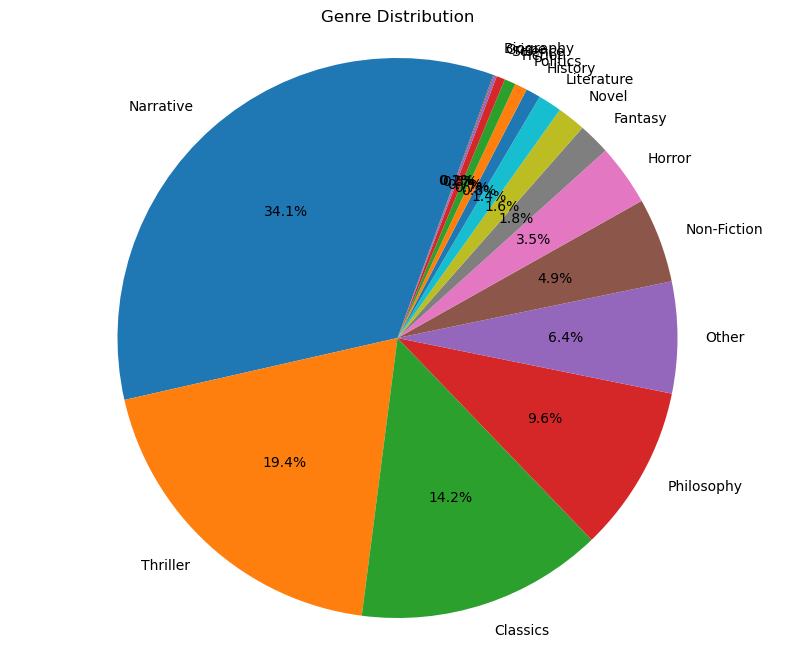

In [369]:
genre_count = full_df['Genre'].value_counts()

# Pie chart
plt.figure(figsize=(10, 8))
plt.pie(genre_count, labels=genre_count.index, autopct='%1.1f%%', startangle=70)
plt.axis('equal')
plt.title('Genre Distribution')
plt.show()

In [370]:
full_df.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,User-ID,Book-Rating,Location,Age,Genre
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0,Philosophy
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",35.0,Other
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0,"timmins, ontario, canada",35.0,Philosophy
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0,"timmins, ontario, canada",35.0,Narrative
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0,"timmins, ontario, canada",35.0,Narrative


In [371]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 241071 entries, 0 to 1031135
Data columns (total 12 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ISBN                 241071 non-null  object 
 1   Book-Title           241071 non-null  object 
 2   Book-Author          241071 non-null  object 
 3   Year-Of-Publication  241071 non-null  object 
 4   Publisher            241071 non-null  object 
 5   Image-URL-S          241071 non-null  object 
 6   Image-URL-M          241071 non-null  object 
 7   User-ID              241071 non-null  int64  
 8   Book-Rating          241071 non-null  int64  
 9   Location             241071 non-null  object 
 10  Age                  241071 non-null  float64
 11  Genre                241071 non-null  object 
dtypes: float64(1), int64(2), object(9)
memory usage: 23.9+ MB


In [372]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\suij2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\suij2\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [383]:

def preprocess_text(text):
    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize
    import re
    stop_words = set(stopwords.words('english'))

    
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    lower_text = text.lower()

    tokens = word_tokenize(lower_text)
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

In [384]:
full_df['combined'] = full_df['Book-Title'] + ' ' + full_df['Genre']

full_df['processed'] = full_df['combined'].parallel_apply(preprocess_text)

In [385]:
processed_corpus = full_df['processed'].tolist()

In [386]:
word2vec_model_rec = Word2Vec(processed_corpus, 
                              vector_size=100, 
                              window=10, 
                              min_count=1, 
                              workers=10, 
                              epochs = 5)

word2vec_model_rec.alpha = 0.025  
word2vec_model_rec.min_alpha = 0.025  

word2vec_model_rec.train(
    processed_corpus,
    total_examples=word2vec_model_rec.corpus_count,
    epochs=4  
)


(4456140, 5227708)

In [387]:
def book_vector(model, book_tokens):
    vector = np.zeros(model.vector_size)
    num_tokens = 0
    for token in book_tokens:
        if token in model.wv:
            vector += model.wv[token]
            num_tokens += 1
    if num_tokens > 0:
        vector /= num_tokens
    return vector

book_vectors = np.array([book_vector(word2vec_model_rec, book) for book in processed_corpus])

In [388]:
index = full_df.isin(['Animal Farm']).any(axis=1).idxmax()
index

182

In [389]:
def recommend_books(book_name, book_vectors, top_n=5):
    book_index = full_df.isin([book_name]).any(axis=1).idxmax()
    similarities = cosine_similarity([book_vectors[book_index]], book_vectors)[0]
    most_similar_indices = similarities.argsort()[-top_n-1:-1][::-1]
    return most_similar_indices

# Assuming you want recommendations for the first book in your dataset
recommended_book_indices = recommend_books('Animal Farm', book_vectors, top_n=10)

In [390]:
recommended_book_indices

array([175463,  35404,  93100,  59723,  71582,   5578, 107957,  11384,
        20654,  87569], dtype=int64)

In [391]:
recs = full_df.iloc[recommended_book_indices]

In [392]:
recs

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,User-ID,Book-Rating,Location,Age,Genre,combined,processed
606305,0553213326,Kim (Bantam Classics),Rudyard Kipling,1983,Bantam,http://images.amazon.com/images/P/0553213326.0...,http://images.amazon.com/images/P/0553213326.0...,91184,0,"kuala lumpur, kuala lumpur, malaysia",31.0,Classics,Kim (Bantam Classics) Classics,"[kim, bantam, classics, classics]"
54149,0553212605,Kidnapped (Bantam Classics),Robert Louis Stevenson,1990,Bantam Books,http://images.amazon.com/images/P/0553212605.0...,http://images.amazon.com/images/P/0553212605.0...,36606,0,"san marcos, california, usa",39.0,Classics,Kidnapped (Bantam Classics) Classics,"[kidnapped, bantam, classics, classics]"
216061,0553210858,The Deerslayer (Bantam Classics),James Fenimore Cooper,1991,Bantam,http://images.amazon.com/images/P/0553210858.0...,http://images.amazon.com/images/P/0553210858.0...,29855,0,"morris, connecticut, usa",53.0,Classics,The Deerslayer (Bantam Classics) Classics,"[deerslayer, bantam, classics, classics]"
116547,0553213075,The Tempest (Bantam Classics),William Shakespeare,1988,Bantam,http://images.amazon.com/images/P/0553213075.0...,http://images.amazon.com/images/P/0553213075.0...,216683,8,"san jose, california, usa",35.0,Classics,The Tempest (Bantam Classics) Classics,"[tempest, bantam, classics, classics]"
152054,0553213695,The Metamorphosis (Bantam Classics),FRANZ KAFKA,1972,Bantam,http://images.amazon.com/images/P/0553213695.0...,http://images.amazon.com/images/P/0553213695.0...,7210,3,"rothesay, new brunswick, canada",35.0,Classics,The Metamorphosis (Bantam Classics) Classics,"[metamorphosis, bantam, classics, classics]"
6028,0553213393,Inferno (Bantam Classics),DANTE,1982,Bantam Classics,http://images.amazon.com/images/P/0553213393.0...,http://images.amazon.com/images/P/0553213393.0...,11676,0,"n/a, n/a, n/a",35.0,Classics,Inferno (Bantam Classics) Classics,"[inferno, bantam, classics, classics]"
268259,0553213024,Othello (Bantam Classics),William Shakespeare,1988,Bantam,http://images.amazon.com/images/P/0553213024.0...,http://images.amazon.com/images/P/0553213024.0...,101550,9,"villa ballester, buenos aires, argentina",29.0,Classics,Othello (Bantam Classics) Classics,"[othello, bantam, classics, classics]"
12529,0553212710,Dracula (Bantam Classics),BRAM STOKER,1983,Bantam,http://images.amazon.com/images/P/0553212710.0...,http://images.amazon.com/images/P/0553212710.0...,177458,0,"ottawa, ontario, canada",29.0,Classics,Dracula (Bantam Classics) Classics,"[dracula, bantam, classics, classics]"
26305,0553212923,Hamlet (Bantam Classics),William Shakespeare,1988,Bantam,http://images.amazon.com/images/P/0553212923.0...,http://images.amazon.com/images/P/0553212923.0...,245827,0,"albuquerque, ,",35.0,Classics,Hamlet (Bantam Classics) Classics,"[hamlet, bantam, classics, classics]"
199250,0553211587,Pudd'Nhead Wilson (Bantam Classics),Mark Twain,1984,Bantam,http://images.amazon.com/images/P/0553211587.0...,http://images.amazon.com/images/P/0553211587.0...,2766,8,"frisco, texas, usa",42.0,Classics,Pudd'Nhead Wilson (Bantam Classics) Classics,"[puddnhead, wilson, bantam, classics, classics]"


In [393]:
full_df[full_df["Book-Title"] == "Animal Farm"]

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,User-ID,Book-Rating,Location,Age,Genre,combined,processed
182,0451526341,Animal Farm,George Orwell,2004,Signet,http://images.amazon.com/images/P/0451526341.0...,http://images.amazon.com/images/P/0451526341.0...,11676,10,"n/a, n/a, n/a",35.0,Classics,Animal Farm Classics,"[animal, farm, classics]"
